# Environments

# Eval

In [2]:
"""
In this demo, we evaluate the performance of the
lofi bandit on a tabular dataset
"""
import os
import re
import jax
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import flax.linen as nn
from datetime import datetime
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

from bandits import training as btrain
from bandits.agents.linear_bandit import LinearBandit
# from bandits.agents.ekf_subspace import SubspaceNeuralBandit
from bandits.agents.low_rank_filter_bandit import LowRankFilterBandit
from bandits.agents.neural_linear import NeuralLinearBandit
from bandits.agents.neural_greedy import NeurawlGreedyBandit
from bandits.environments.mnist_env import MnistEnvironment

import lofi_tabular as experiment

/home/gerardoduran/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 14

In [4]:
ntrials = 1
npulls = 20
key = jax.random.PRNGKey(314)
key_env, key_train, key_eval = jax.random.split(key, 3)

# env = TabularEnvironment(key_env, ntrain=ntrain, name='statlog', intercept=False, path="../bandit-data")
env = MnistEnvironment(key, ntrain=500)
env_test = MnistEnvironment(key, ntrain=25_000)

num_arms = env.labels_onehot.shape[-1]

/home/gerardoduran/mambaforge/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [7]:
class MLP(nn.Module):
    num_arms: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(500)(x)
        x = nn.elu(x)
        x = nn.Dense(300)(x)
        x = nn.elu(x)
        x = nn.Dense(200, name="last_layer")(x)
        x = nn.elu(x)
        x = nn.Dense(self.num_arms)(x)
        return x
model = MLP(num_arms)

In [8]:
optimisers = {}
results = {}

## LoFi: Fixed dynamics

Setting $\gamma=1.0$, $q = 0.0$.

In [13]:
name_agent = "lofi-fixed"
extra_params = {
    "memory_size": 15,
    "model": model,
    "dynamics_weights": 1.0,
    "dynamics_covariance": 0.0,

}

@jax.jit
def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_lofi_fixed,
        LowRankFilterBandit,
        env,
        key_train,
        npulls,
        **extra_params,
    )

    
    return res["hist_train"]["rewards"].sum()

In [15]:
%%time
# try q=0, γ=1
pbounds = {
    "log_em_cov": [-10., 0], # empirical covariance
    "log_init_cov": [-10., 0],
}


optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)

# LoFi
optimiser.maximize(init_points=5, n_iter=15)

|   iter    |  target   | log_em... | log_in... |
-------------------------------------------------
| 1         | 48.0      | -5.738    | -2.971    |
| 2         | 47.0      | -1.514    | -9.956    |
| 3         | 179.0     | -9.159    | -9.927    |
| 4         | 61.0      | -4.961    | -5.19     |
| 5         | 49.0      | -1.243    | -1.285    |
| 6         | 141.0     | -9.99     | -7.321    |
| 7         | 162.0     | -10.0     | -10.0     |
| 8         | 161.0     | -6.702    | -10.0     |
| 9         | 46.0      | -10.0     | 0.0       |
| 10        | 155.0     | -8.092    | -8.737    |
| 11        | 182.0     | -8.132    | -10.0     |
| 12        | 175.0     | -8.611    | -10.0     |
| 13        | 54.0      | 0.0       | -5.691    |
| 14        | 108.0     | -10.0     | -4.502    |
| 15        | 146.0     | -9.731    | -8.868    |
| 16        | 106.0     | -8.042    | -6.302    |
| 17        | 43.0      | -4.994    | 0.0       |
| 18        | 131.0     | -5.443    | -8.319    |


In [16]:
%%time
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_lofi_fixed,
    LowRankFilterBandit,
    env_test,
    key_eval,
    npulls,
    n_trials=8,
    **extra_params,
)

res = jax.tree_map(np.array, res)
results[name_agent] = res
optimisers[name_agent] = optimiser

CPU times: user 38 s, sys: 1.43 s, total: 39.4 s
Wall time: 3min 7s


## Subspace EKF: Fixed dynamics


## Linear

## Neural linear

In [17]:
name_agent = "neural-linear"
extra_params = {
    "model": model,
    "update_step_mod": 100,
    "nepochs": 100,
    "batch_size": 1000,

}


extra_params = {
    "model": model,
    "update_step_mod": 1,
    "nepochs": 1,
    "batch_size": 1,

}


@jax.jit
def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_neural_linear,
        NeuralLinearBandit,
        env,
        key_train,
        npulls,
        **extra_params
    )
    
    return res["hist_train"]["rewards"].sum()

In [18]:
%%time
pbounds = {
    "eta": [0, 10],
    "log_lambda": [-15, 0], # -15, 0 
    "log_lr": [-10, -2]
}


optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)
# Neural linear
optimiser.maximize(init_points=5, n_iter=15)

|   iter    |  target   |    eta    | log_la... |  log_lr   |
-------------------------------------------------------------
| 1         | 45.0      | 4.262     | -4.456    | -3.211    |
| 2         | 45.0      | 0.04448   | -13.74    | -9.942    |
| 3         | 45.0      | 5.039     | -7.785    | -2.994    |
| 4         | 45.0      | 8.715     | -0.527    | -2.535    |
| 5         | 45.0      | 0.375     | -13.03    | -4.983    |
| 6         | 83.0      | 9.699     | -0.1943   | -9.638    |
| 7         | 43.0      | 10.0      | -3.63     | -10.0     |
| 8         | 56.0      | 9.86      | -1.921    | -7.315    |
| 9         | 95.0      | 9.695     | -0.1085   | -8.892    |
| 10        | 101.0     | 8.708     | 0.0       | -8.654    |
| 11        | 95.0      | 6.619     | 0.0       | -8.166    |
| 12        | 104.0     | 4.061     | 0.0       | -10.0     |
| 13        | 174.0     | 1.018     | 0.0       | -9.469    |
| 14        | 301.0     | 0.0       | 0.0       | -7.514    |
| 15    

In [19]:
%%time
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_neural_linear,
    NeuralLinearBandit,
    env_test,
    key_eval,
    npulls,
    n_trials=8,
    **extra_params
)

results[name_agent] = res
optimisers[name_agent] = optimiser

CPU times: user 21.3 s, sys: 902 ms, total: 22.2 s
Wall time: 9.46 s


## Neural Greedy (replay-buffer)

In [20]:
name_agent = "rsgd"
extra_params = {
    "model": model,
    "memory_size": 1,
    "epsilon": 0.01,
    "n_inner": 1.0,

}

@jax.jit
def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_rsgd,
        NeuralGreedyBandit,
        env,
        key_train,
        npulls,
        **extra_params
    )
    
    return res["hist_train"]["rewards"].sum()

In [21]:
%%time
pbounds = {
    "log_lr": [-10, -2]
}


optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)

optimiser.maximize(init_points=5, n_iter=15)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | 33.0      | -6.59     |
| 2         | 40.0      | -4.377    |
| 3         | 49.0      | -3.211    |
| 4         | 131.0     | -9.964    |
| 5         | 142.0     | -9.327    |
| 6         | 118.0     | -8.509    |
| 7         | 135.0     | -9.521    |
| 8         | 47.0      | -2.0      |
| 9         | 135.0     | -8.986    |
| 10        | 77.0      | -7.765    |
| 11        | 140.0     | -9.205    |
| 12        | 50.0      | -5.454    |
| 13        | 142.0     | -9.298    |
| 14        | 142.0     | -9.313    |
| 15        | 142.0     | -9.314    |
| 16        | 142.0     | -9.312    |
| 17        | 142.0     | -9.324    |
| 18        | 142.0     | -9.308    |
| 19        | 142.0     | -9.319    |
| 20        | 142.0     | -9.309    |
CPU times: user 1min 9s, sys: 1min 17s, total: 2min 27s
Wall time: 37.6 s


In [22]:
%%time
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_rsgd,
    NeuralGreedyBandit,
    env_test,
    key_eval,
    npulls,
    n_trials=8,
    **extra_params
)

results[name_agent] = res
optimisers[name_agent] = optimiser

CPU times: user 4.4 s, sys: 275 ms, total: 4.67 s
Wall time: 3.89 s


## Plots

In [23]:
results.keys()

dict_keys(['lofi-fixed', 'neural-linear', 'rsgd'])

In [24]:
name_mapping = {
    "lofi-fixed": "Neural-Lofi TS",
    "linear": "Linear TS",
    "neural-linear": "Neural-linear TS",
    "rsgd": "OGD Greedy",
}

In [ ]:
filename = "bandit-showdown-mem10.pkl"
path = os.path.join("output", "results", filename)

with open(path, "wb") as f:
    pickle.dump(results, f)

lofi-fixed - 21174.25±405.13
neural-linear - 20991.50±24.02
rsgd - 20892.12±213.12


Text(0.5, 1.0, 'MNIST environment')

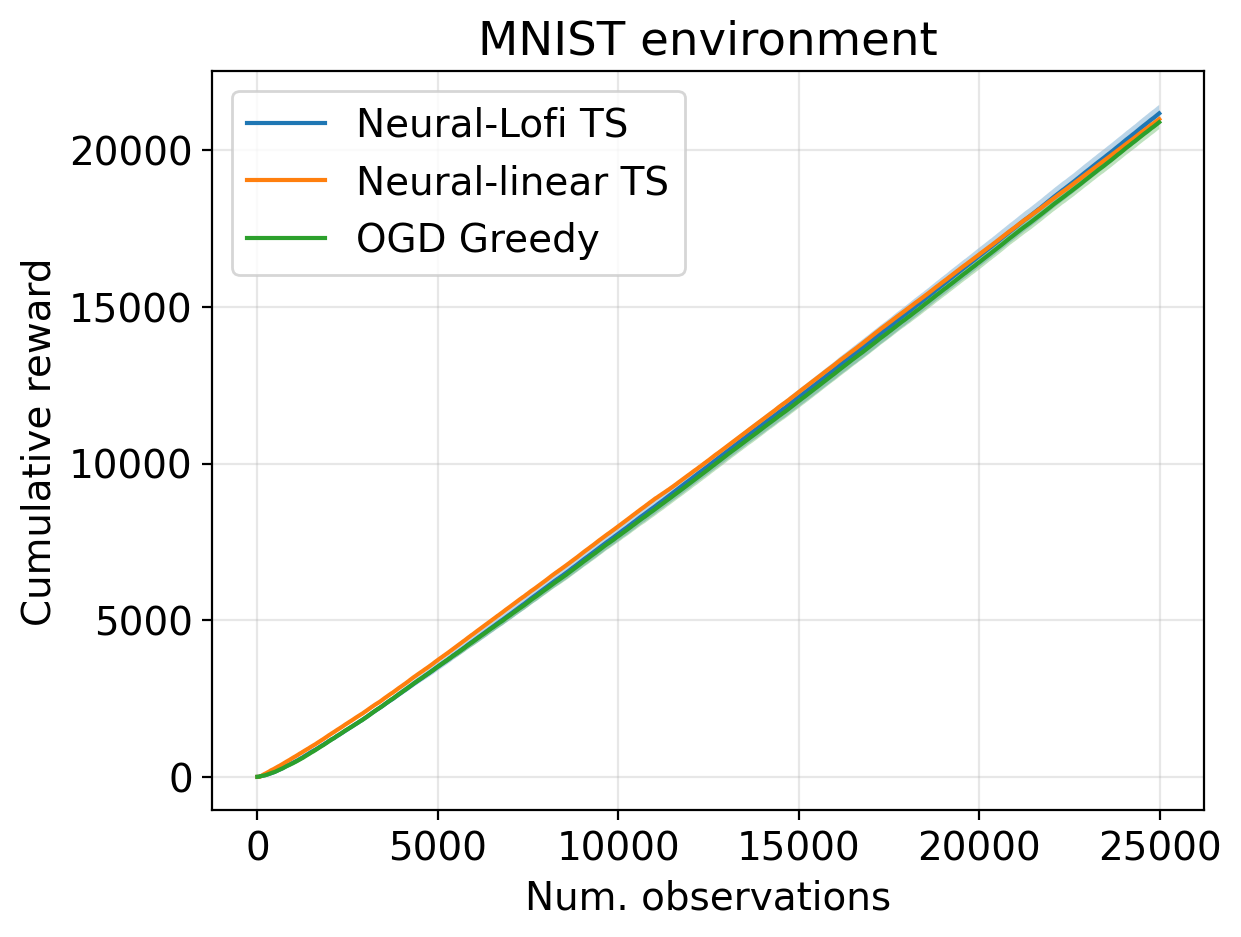

In [56]:
for name, res in results.items():
    label = name_mapping[name]
    rewards = res["hist_train"]["rewards"]
    mean_reward = rewards.sum(axis=1).mean()
    std_reward = rewards.sum(axis=1).std()

    rewards = pd.DataFrame(rewards).T.cumsum(axis=0)
    # rewards = rewards.apply(lambda x: np.arange(len(x)) - x)
    print(f"{name} - {mean_reward:0.2f}±{std_reward:0.2f}")

    nsteps = len(rewards)
    rmean = rewards.mean(axis=1)
    ubound = rewards.quantile(0.9, axis=1)
    lbound = rewards.quantile(0.1, axis=1)
    
    plt.fill_between(rewards.index, lbound, ubound, alpha=0.3)
    plt.plot(rewards.index, rmean, label=label)
    
# plt.plot([0, nsteps], [0, nsteps], c="tab:gray", linewidth=1, linestyle="--", label="oracle")
plt.legend()
plt.grid(alpha=0.3)
plt.ylabel("Cumulative reward")
plt.xlabel("Num. observations")
plt.title("MNIST environment")
# plt.savefig("./output/figures/mnist-bandits-regret.pdf")

In [29]:
def get_subtree(tree, key):
    return jax.tree_map(lambda x: x[key], tree, is_leaf=lambda x: key in x)


In [30]:
rewards_all = get_subtree(results, "hist_train")
rewards_all = get_subtree(rewards_all, "rewards")
rewards_all = jax.tree_map(lambda x: np.sum(x, axis=1), rewards_all)
rewards_all = pd.DataFrame(rewards_all)

rewards_all.mean(axis=0)

lofi-fixed       21174.250
neural-linear    20991.500
rsgd             20892.125
dtype: float32

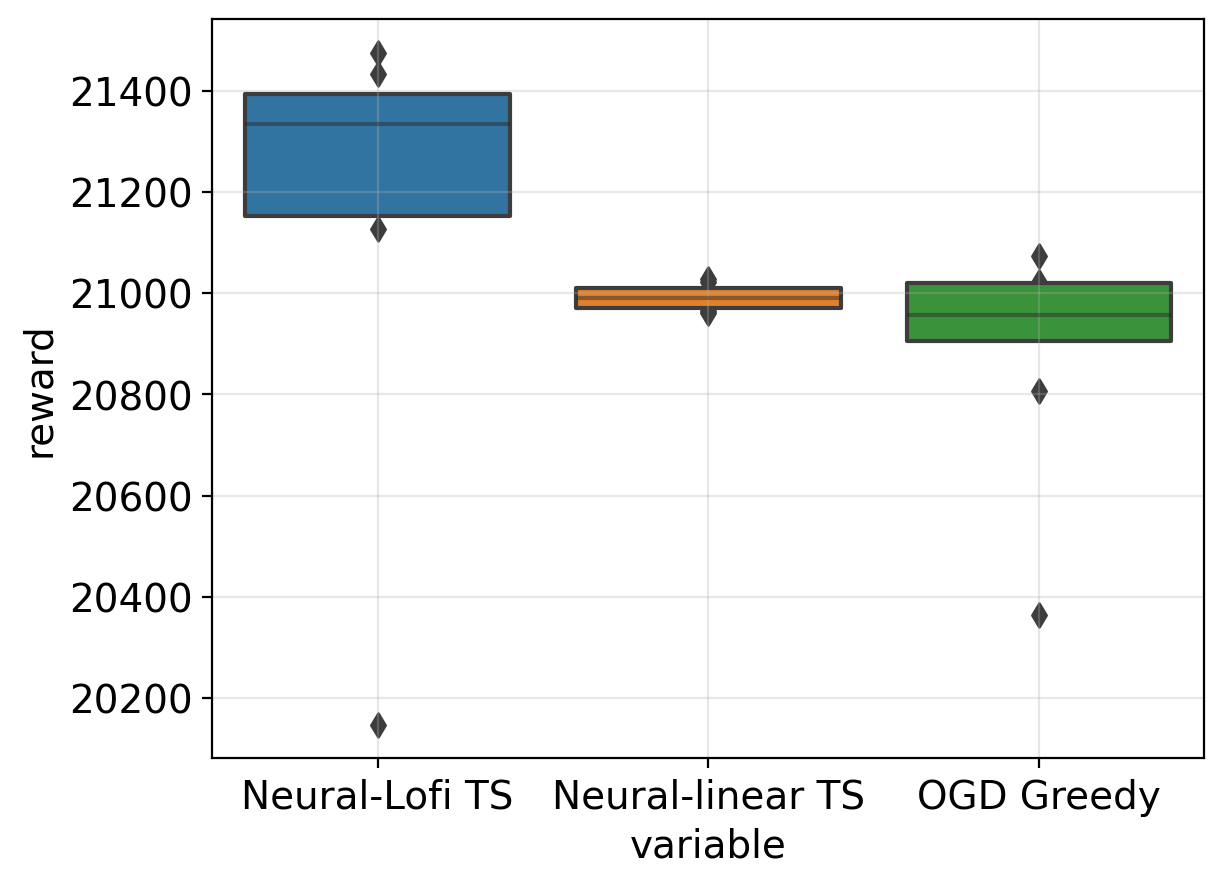

In [31]:
sns.boxenplot(
    x="variable",
    y="reward",
    data=(
        rewards_all
        .rename(name_mapping, axis=1)
        .melt(value_name="reward")
        .query("variable != 'linear'")
    )
)
plt.grid(alpha=0.3)
plt.savefig("./output/figures/mnist-bandits-final-reward.pdf")